## 3. Forest Cover Type Dataset  
- EDA, Feature engineering and Modeling (4th/359)

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.9.28 </div>
<div style="text-align: right\"> Last update: 2021.9.28</div>

- 출처 : https://www.kaggle.com/nadare/eda-feature-engineering-and-modeling-4th-359

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

from sklearn import datasets
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from tqdm import tqdm

import os
import gc
from itertools import combinations, chain
from datetime import datetime

In [4]:
print(os.listdir('data/forest-cover-type-kernels-only/'))

['my_submission.csv', 'output_ceil.csv', 'output_floor.csv', 'sampleSubmission.csv', 'sample_submission.csv', 'sub.csv', 'test.csv', 'train.csv']


In [5]:
train = pd.read_csv('data/forest-cover-type-kernels-only/train.csv')
test = pd.read_csv('data/forest-cover-type-kernels-only/test.csv')
submission = pd.read_csv('data/forest-cover-type-kernels-only/sample_submission.csv')

### Preprocessing

#### EDA & leader board hacking

데이터 분포를 살펴보자. 학습, 시험 데이터 간 분포 차이가 남을 확인할 수 있다.

In [6]:
from scipy.stats import gaussian_kde

def compare_dist(ax, feature, i=0):
    sns.kdeplot(train[feature], label="train", ax=ax)
    sns.kdeplot(test[feature], label="test", ax=ax)

In [7]:
def numeric_tile(plot_func):
    fig, axs = plt.subplots(2, 5, figsize=(24, 6))
    axs = axs.flatten()
    
    for i, (ax, col) in enumerate(zip(axs, train.columns.tolist()[1:11])):
        plot_func(ax, col, i)
        ax.set_title(col)
        #plt.legend()
    plt.tight_layout()

In [8]:
train.columns[1:11]

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'],
      dtype='object')

In [9]:
train.columns[12:]

Index(['Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type'],
      dtype='object')

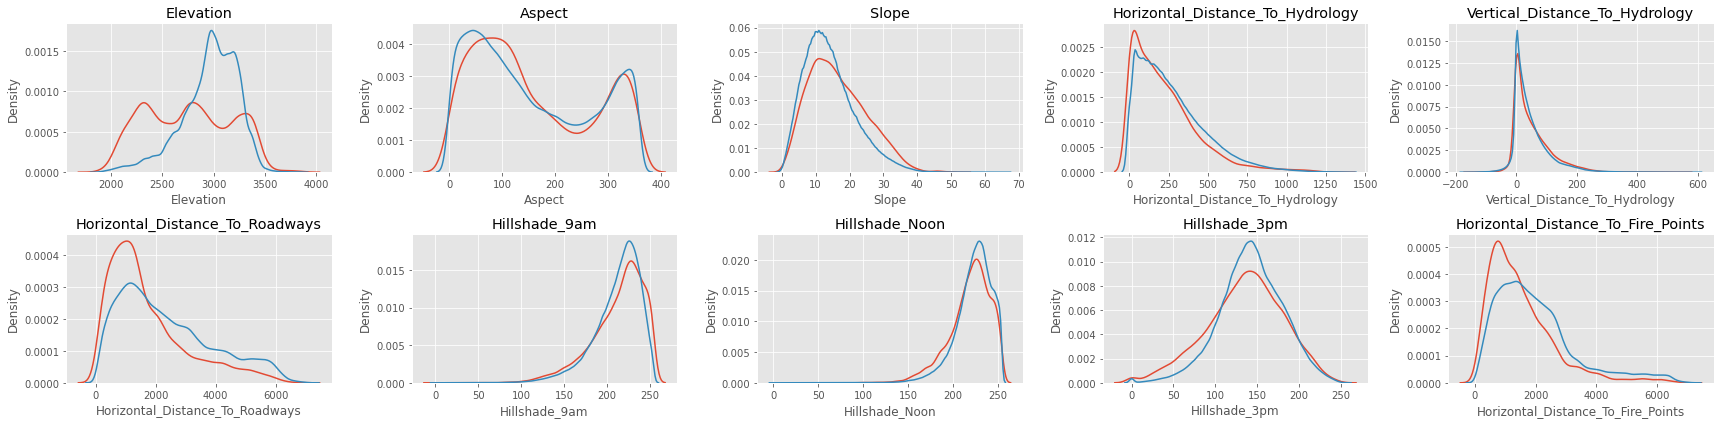

In [10]:
numeric_tile(compare_dist)

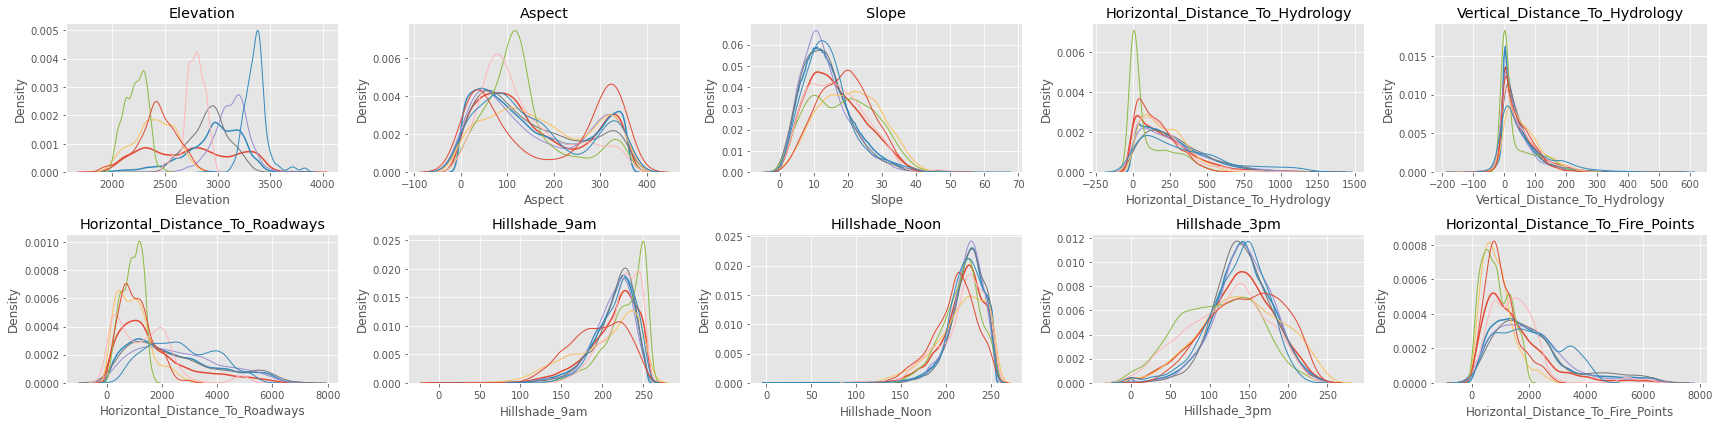

In [11]:
# For the training data, display the distribution of variables for each target.

# Please pay attention to "Elevation". The difference between the training data and the test data distribution is
# thought to be due to the difference between the proportion of the target variables in the training data and the test data.

def compare_target(ax, feature, i=0):
    sns.kdeplot(train.loc[:, feature], label="train", ax=ax)
    sns.kdeplot(test.loc[:, feature], label="test", ax=ax)
    for target in range(1, 8):
        sns.kdeplot(train.loc[train["Cover_Type"] == target, feature], label=target, alpha=0.5, lw=1, ax=ax)

numeric_tile(compare_target) 

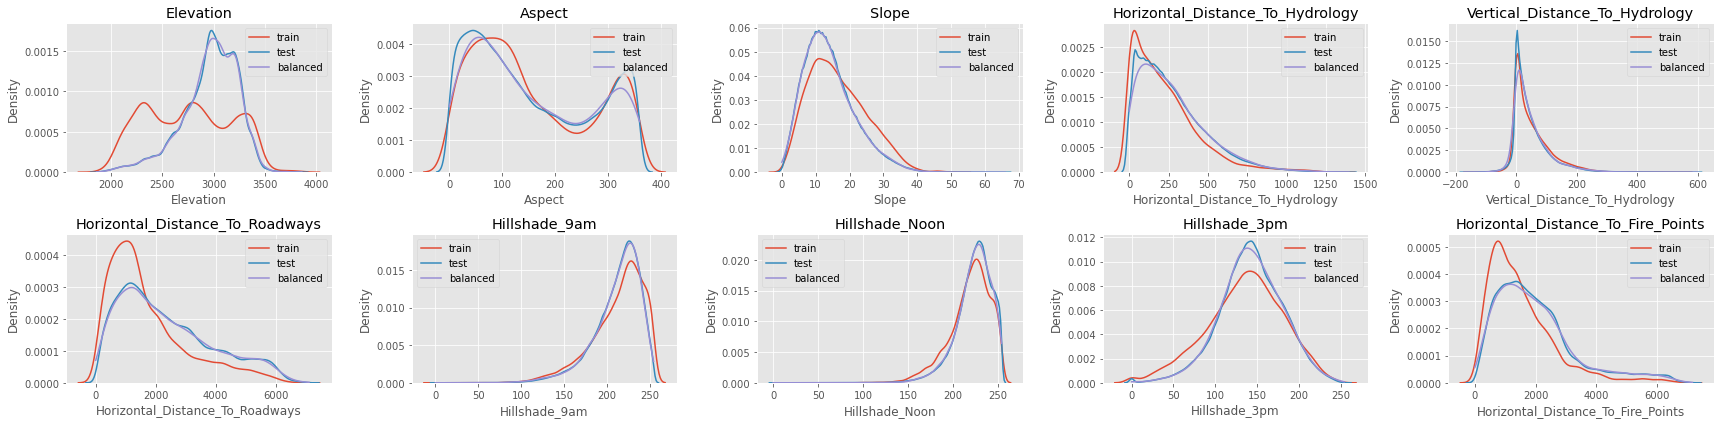

In [12]:
# I was able to obtain the distribution of the test data by submitting prediction data with all the same purpose variables.

"""
smpsb = pd.read_csv("../input/sample_submission.csv")
for i in range(1, 8):
    smpsb["Cover_Type"] = i
    smpsb.to_csv("all_{}.csv".format(i), index=None)"""

# and this is the magic number of this competition.
type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])
class_weight = {k: v for k, v in enumerate(type_ratio, start=1)}

# By using these numbers, you can mimic the distribution of the test data from the training data.
def compare_balanced_dist(ax, feature, i=0):
    min_ = min(train[feature].min(), test[feature].min())
    max_ = max(train[feature].max(), test[feature].max())
    X = np.linspace(min_, max_, 1000)

    sns.kdeplot(train[feature], label="train", ax=ax)
    sns.kdeplot(test[feature], label="test", ax=ax)
    btest = np.zeros(1000)
    
    for target in range(1, 8):
        btest += gaussian_kde(train.loc[train["Cover_Type"] == target, feature])(X) * type_ratio[target-1]
    
    ax.plot(X, btest, label="balanced")
    ax.legend()

numeric_tile(compare_balanced_dist)

In [13]:
# By using the following functions, it is possible to perform almost the same evaluation
# as the leader board even in the local environment.

def balanced_accuracy_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred, sample_weight=np.apply_along_axis(lambda x: type_ratio[x], 0, y_true-1))

#### feature engineering 1 : 중요하다고 생각되는 부분을 정리함

Aspect(경사도)

In [14]:
# The angle can be divided into sine and cosine
sin_ = np.sin(np.pi*train["Aspect"]/180)
cos_ = np.cos(np.pi*train["Aspect"]/180)

In [15]:
sin_

0        0.777146
1        0.829038
2        0.656059
3        0.422618
4        0.707107
           ...   
15115   -0.891007
15116    0.857167
15117    0.719340
15118    0.224951
15119   -0.292372
Name: Aspect, Length: 15120, dtype: float64

In [16]:
np.where(train["Cover_Type"] == 1)

(array([   40,    51,    52, ..., 14858, 14864, 14873], dtype=int64),)

In [17]:
np.where(train["Cover_Type"] == 1)[0] 

array([   40,    51,    52, ..., 14858, 14864, 14873], dtype=int64)

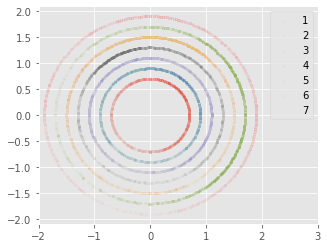

In [18]:
# However, if this feature quantity alone, the effect seems to be light.
plt.figure(figsize=(5, 4))
for i in range(1, 8):
    cat = np.where(train["Cover_Type"] == i)[0] #해당 클래스의 index를 추출
    r = (.5+0.2*i)
    plt.scatter(cos_[cat]*(r), sin_[cat]*(r), alpha=0.02*r, s=6, label=i)
plt.xlim(-2, 3)
plt.legend()

#### degree to hydrology

In [21]:
# this may be good feature but unfortunally i forgot to add my data
hydro_h = train["Vertical_Distance_To_Hydrology"]
hydro_v = train["Horizontal_Distance_To_Hydrology"]

No handles with labels found to put in legend.


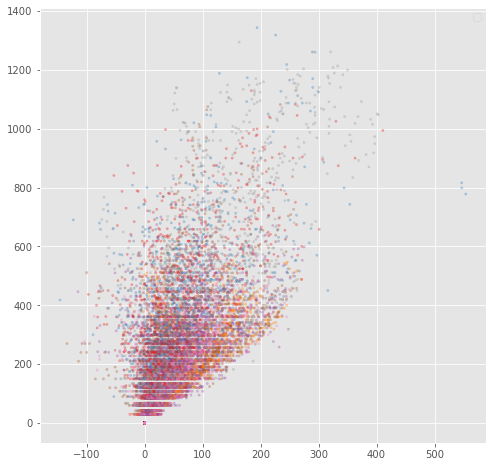

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(hydro_h, hydro_v, s=5, c=train["Cover_Type"], cmap="Set1", alpha=0.3)
plt.legend()

In [28]:
np.where(train["Cover_Type"] == 1)

(array([   40,    51,    52, ..., 14858, 14864, 14873], dtype=int64),)

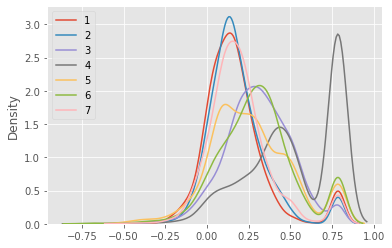

In [30]:
hydro_arctan = np.arctan((hydro_h+0.0001) / (hydro_v+0.0001))
for i in range(1, 8):
    cat = np.where(train["Cover_Type"] == i)[0]
    sns.kdeplot(hydro_arctan[cat])
plt.legend(['1', '2', '3', '4', '5', '6', '7'])

In [31]:
train['Cover_Type'].value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

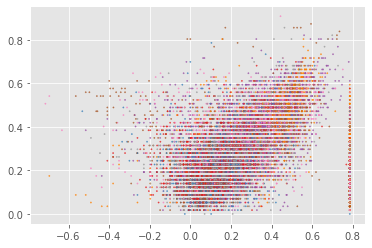

In [34]:
plt.scatter(hydro_arctan, np.pi*train["Slope"]/180, c=train["Cover_Type"], cmap="Set1", s=1.5, alpha=0.7)

#### target_encoding

pandas.filter : 특정 조건을 만족하는 변수만 인덱싱`ㅡ

In [35]:
train.filter(regex='Wilder')

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
15115,0,0,1,0
15116,0,0,1,0
15117,0,0,1,0
15118,0,0,1,0


In [36]:
train.filter(regex='Wilder').sum(axis = 0)

Wilderness_Area1    3597
Wilderness_Area2     499
Wilderness_Area3    6349
Wilderness_Area4    4675
dtype: int64

<AxesSubplot:ylabel='None'>

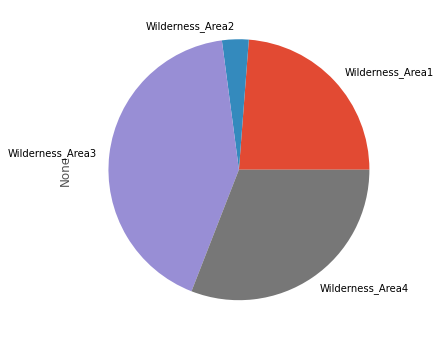

In [42]:
# this is the ratio of Wilderness_Area
plt.figure(figsize=(6, 6))
train.filter(regex="Wilder").sum(axis=0).plot(kind = "pie")

In [43]:
train.filter(regex="Wilder") * np.array([1, 2, 3, 4])

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
15115,0,0,3,0
15116,0,0,3,0
15117,0,0,3,0
15118,0,0,3,0


In [46]:
(train.filter(regex="Wilder") * np.array([1, 2, 3, 4])).sum(axis = 1) #one hot -> label encoding??

0        1
1        1
2        1
3        1
4        1
        ..
15115    3
15116    3
15117    3
15118    3
15119    3
Length: 15120, dtype: int64

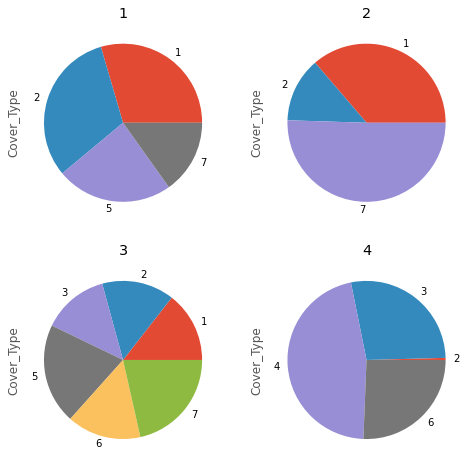

In [48]:
# and this is ratio of "over_Type" in each "Wildereness_area"
wilder = (train.filter(regex="Wilder") * np.array([1, 2, 3, 4])).sum(axis=1)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i, ax in enumerate(axs, start=1):
    train.loc[wilder==i, "Cover_Type"].value_counts().sort_index().plot(kind = "pie", ax=ax)
    ax.set_title(i)

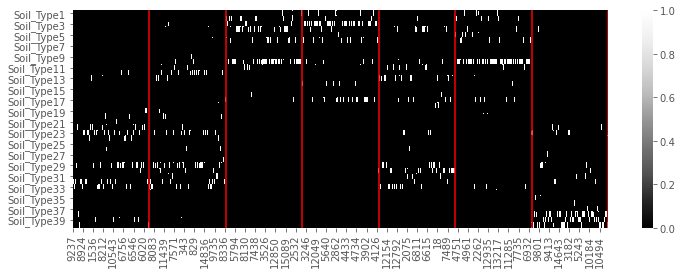

In [49]:
# This shows the expression of Soil_Type for the objective variable.
plt.figure(figsize=(12, 4))
sns.heatmap(train.iloc[:, -41:].sort_values(by="Cover_Type").iloc[:, :-1].T, cmap="Greys_r")
for i in np.linspace(0, train.shape[0], 8)[1:]:
    plt.axvline(i, c="r")

- 위에서 확인한 바와 같이 카테고리 변수가 분류에 중요한 영향을 미친다.  
- 따라서 카테고리 변수를 효과적으로 다루기 위해서 각 카테고리에서 타겟에 대한 비율(?)이 피처에 가해진다?  
- 데이터 leakeage를 방지하고 수가 매우 적은 카테고리에 대한 과도한 신뢰를 방지하기 위해,, we added values for 10 data as prior distribution to each category.??

In [50]:
# this is the code
def categorical_post_mean(x):
    p = (x.values)*type_ratio
    p = p/p.sum()*x.sum() + 10*type_ratio
    return p/p.sum()

- 코드 확인요

#### summarize preprocessing  
- 전처리 과정을 하나로 요약한다.

In [79]:
train = pd.read_csv('data/forest-cover-type-kernels-only/train.csv')
test = pd.read_csv('data/forest-cover-type-kernels-only/test.csv')
submission = pd.read_csv('data/forest-cover-type-kernels-only/sample_submission.csv')

In [80]:
datetime.now()

datetime.datetime(2021, 10, 6, 7, 28, 42, 409036)

In [81]:
type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])

In [82]:
df = pd.concat([train.iloc[:, :-1], test])

In [83]:
print(train.shape)
print(test.shape)
print(df.shape)

(15120, 56)
(565892, 55)
(581012, 55)


In [84]:
# Aspect
df["Aspect_Sin"] = np.sin(np.pi*df["Aspect"]/180)
df["Aspect_Cos"] = np.cos(np.pi*df["Aspect"]/180)

In [85]:
# Hillshade
hillshade_col = ["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]
for col1, col2 in combinations(hillshade_col, 2):
    df[col1 + "_add_" + col2] = df[col2] + df[col1]
    df[col1 + "_dif_" + col2] = df[col2] - df[col1]
    df[col1 + "_div_" + col2] = (df[col2]+0.01) / (df[col1]+0.01)
    df[col1 + "_abs_" + col2] = np.abs(df[col2] - df[col1])
    
df["Hillshade_mean"] = df[hillshade_col].mean(axis=1)
df["Hillshade_std"] = df[hillshade_col].std(axis=1)
df["Hillshade_max"] = df[hillshade_col].max(axis=1)
df["Hillshade_min"] = df[hillshade_col].min(axis=1)

In [87]:
# Hydrology ** I forgot to add arctan
df["Degree_to_Hydrology"] = ((df["Vertical_Distance_To_Hydrology"] + 0.001) /
                                       (df["Horizontal_Distance_To_Hydrology"] + 0.01))

In [88]:
# Holizontal
horizontal_col = ["Horizontal_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                      "Horizontal_Distance_To_Fire_Points"]
        
for col1, col2 in combinations(horizontal_col, 2):
    df[col1 + "_add_" + col2] = df[col2] + df[col1]
    df[col1 + "_dif_" + col2] = df[col2] - df[col1]
    df[col1 + "_div_" + col2] = (df[col2]+0.01) / (df[col1]+0.01)
    df[col1 + "_abs_" + col2] = np.abs(df[col2] - df[col1])

In [89]:
def categorical_post_mean(x):
    p = (x.values)*type_ratio
    p = p/p.sum()*x.sum() + 10*type_ratio
    return p/p.sum()

In [90]:
# Wilder

In [94]:
wilder = pd.DataFrame([(train.iloc[:, 11:15] * np.arange(1, 5)).sum(axis=1),
                          train['Cover_Type']]).T

In [95]:
wilder.head()

,Unnamed 0,Cover_Type
0,1,5
1,1,5
2,1,2
3,1,2
4,1,5


In [96]:
wilder.value_counts()

Unnamed 0  Cover_Type
4          4             2160
3          7             1363
           5             1304
4          3             1297
           6             1198
1          2             1134
           1             1062
3          6              962
           2              940
           1              917
           3              863
1          5              856
           7              545
2          7              252
           1              181
           2               66
4          2               20
dtype: int64

In [97]:
wilder.columns = ["Wilder_Type", "Cover_Type"]
wilder["one"] = 1

In [98]:
wilder.head()

,Wilder_Type,Cover_Type,one
0,1,5,1
1,1,5,1
2,1,2,1
3,1,2,1
4,1,5,1


In [99]:
piv = wilder.pivot_table(values="one",
                             index="Wilder_Type",
                             columns="Cover_Type",
                             aggfunc="sum").fillna(0)

In [100]:
piv

Cover_Type,1,2,3,4,5,6,7
Wilder_Type,,,,,,,
1,1062.0,1134.0,0.0,0.0,856.0,0.0,545.0
2,181.0,66.0,0.0,0.0,0.0,0.0,252.0
3,917.0,940.0,863.0,0.0,1304.0,962.0,1363.0
4,0.0,20.0,1297.0,2160.0,0.0,1198.0,0.0


In [101]:
tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()

In [102]:
tmp

,index,0,1,2,3,4,5,6
0,0,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967
1,1,0.615919,0.307333,0.001166,0.000020,0.000254,0.000528,0.074780
2,2,0.359595,0.494222,0.054221,0.000002,0.017863,0.027355,0.046741
3,3,0.000791,0.082772,0.633264,0.018298,0.000028,0.264778,0.000069


In [103]:
tmp["index"] = piv.sum(axis=1).index

In [104]:
tmp

,index,0,1,2,3,4,5,6
0,1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967
1,2,0.615919,0.307333,0.001166,0.000020,0.000254,0.000528,0.074780
2,3,0.359595,0.494222,0.054221,0.000002,0.017863,0.027355,0.046741
3,4,0.000791,0.082772,0.633264,0.018298,0.000028,0.264778,0.000069


In [106]:
tmp.columns = ["Wilder_Type"] + ["Wilder_prob_ctype_{}".format(i) for i in range(1, 8)]
tmp["Wilder_Type_count"] = piv.sum(axis=1).values

In [107]:
tmp

,Wilder_Type,Wilder_prob_ctype_1,Wilder_prob_ctype_2,Wilder_prob_ctype_3,Wilder_prob_ctype_4,Wilder_prob_ctype_5,Wilder_prob_ctype_6,Wilder_prob_ctype_7,Wilder_Type_count
0,1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,3597.0
1,2,0.615919,0.307333,0.001166,0.000020,0.000254,0.000528,0.074780,499.0
2,3,0.359595,0.494222,0.054221,0.000002,0.017863,0.027355,0.046741,6349.0
3,4,0.000791,0.082772,0.633264,0.018298,0.000028,0.264778,0.000069,4675.0


In [108]:
df.filter(regex="Wilder")

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
565887,0,0,1,0
565888,0,0,1,0
565889,0,0,1,0
565890,0,0,1,0


In [109]:
df["Wilder_Type"] = (df.filter(regex="Wilder") * np.arange(1, 5)).sum(axis=1)

In [111]:
df['Wilder_Type'].value_counts()

1    260796
3    253364
4     36968
2     29884
Name: Wilder_Type, dtype: int64

In [112]:
df = df.merge(tmp, on="Wilder_Type", how="left")

In [113]:
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Horizontal_Distance_To_Roadways_abs_Horizontal_Distance_To_Fire_Points,Wilder_Type,Wilder_prob_ctype_1,Wilder_prob_ctype_2,Wilder_prob_ctype_3,Wilder_prob_ctype_4,Wilder_prob_ctype_5,Wilder_prob_ctype_6,Wilder_prob_ctype_7,Wilder_Type_count
0,1,2596,51,3,258,0,510,221,232,148,...,5769,1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,3597.0
1,2,2590,56,2,212,-6,390,220,235,151,...,5835,1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,3597.0
2,3,2804,139,9,268,65,3180,234,238,135,...,2941,1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,3597.0
3,4,2785,155,18,242,118,3090,238,238,122,...,3121,1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,3597.0
4,5,2595,45,2,153,-1,391,220,234,150,...,5781,1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,3597.0


In [117]:
df.filter(regex='Wilder_prob')

,Wilder_prob_ctype_1,Wilder_prob_ctype_2,Wilder_prob_ctype_3,Wilder_prob_ctype_4,Wilder_prob_ctype_5,Wilder_prob_ctype_6,Wilder_prob_ctype_7
0,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967
1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967
2,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967
3,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967
4,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967
...,...,...,...,...,...,...,...
581007,0.359595,0.494222,0.054221,0.000002,0.017863,0.027355,0.046741
581008,0.359595,0.494222,0.054221,0.000002,0.017863,0.027355,0.046741
581009,0.359595,0.494222,0.054221,0.000002,0.017863,0.027355,0.046741
581010,0.359595,0.494222,0.054221,0.000002,0.017863,0.027355,0.046741


In [119]:
df.filter(regex='Wilder_prob').isnull().sum()

Wilder_prob_ctype_1    0
Wilder_prob_ctype_2    0
Wilder_prob_ctype_3    0
Wilder_prob_ctype_4    0
Wilder_prob_ctype_5    0
Wilder_prob_ctype_6    0
Wilder_prob_ctype_7    0
dtype: int64

In [120]:
for i in range(7):
    df.loc[:, "Wilder_prob_ctype_{}".format(i+1)] = df.loc[:, "Wilder_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])

In [123]:
df['Wilder_Type_count'].isnull().sum()

0

In [124]:
df.loc[:, "Wilder_Type_count"] = df.loc[:, "Wilder_Type_count"].fillna(0)

In [125]:
# Soil type

In [127]:
train.iloc[:, -41:-1].head()

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
soil = pd.DataFrame([(train.iloc[:, -41:-1] * np.arange(1, 41)).sum(axis=1), train['Cover_Type']]).T
soil.columns = ["Soil_Type", "Cover_Type"]
soil["one"] = 1

In [131]:
soil

,Soil_Type,Cover_Type,one
0,29,5,1
1,29,5,1
2,12,2,1
3,30,2,1
4,29,5,1
...,...,...,...
15115,4,3,1
15116,4,3,1
15117,4,3,1
15118,4,3,1


In [132]:
piv = soil.pivot_table(values="one", index="Soil_Type", columns="Cover_Type", aggfunc="sum").fillna(0)

In [133]:
piv

Cover_Type,1,2,3,4,5,6,7
Soil_Type,,,,,,,
1,0.0,0.0,121.0,139.0,0.0,95.0,0.0
2,0.0,3.0,283.0,94.0,61.0,182.0,0.0
3,0.0,12.0,133.0,799.0,0.0,18.0,0.0
4,5.0,20.0,462.0,133.0,129.0,87.0,7.0
5,0.0,0.0,55.0,39.0,0.0,71.0,0.0
6,0.0,7.0,248.0,244.0,0.0,151.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,9.0,0.0,0.0,0.0,0.0,0.0
10,9.0,81.0,717.0,170.0,64.0,1101.0,0.0


In [134]:
tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
tmp["index"] = piv.sum(axis=1).index
tmp.columns = ["Soil_Type"] + ["Soil_prob_ctype_{}".format(i) for i in range(1, 8)]

In [135]:
tmp

,Soil_Type,Soil_prob_ctype_1,Soil_prob_ctype_2,Soil_prob_ctype_3,Soil_prob_ctype_4,Soil_prob_ctype_5,Soil_prob_ctype_6,Soil_prob_ctype_7
0,1,0.010152,0.013611,0.708805,0.014124,0.000355,0.252064,0.000888
1,2,0.005854,0.068800,0.687932,0.003976,0.032510,0.200416,0.000512
2,3,0.003812,0.394236,0.515914,0.053726,0.000133,0.031845,0.000334
3,4,0.046352,0.231123,0.622529,0.003118,0.038031,0.053321,0.005526
4,5,0.021173,0.028389,0.593915,0.007325,0.000740,0.346605,0.001853
5,6,0.005614,0.159697,0.645047,0.011012,0.000196,0.177942,0.000491
6,8,0.336855,0.542569,0.053965,0.000936,0.011773,0.024428,0.029474
7,9,0.223532,0.710152,0.029680,0.000515,0.006475,0.013435,0.016210
8,10,0.030158,0.345462,0.363208,0.001498,0.007128,0.252396,0.000151
9,11,0.049776,0.746238,0.117971,0.000570,0.044306,0.040360,0.000779


In [136]:
tmp["Soil_Type_count"] = piv.sum(axis=1).values

In [138]:
tmp.head()

,Soil_Type,Soil_prob_ctype_1,Soil_prob_ctype_2,Soil_prob_ctype_3,Soil_prob_ctype_4,Soil_prob_ctype_5,Soil_prob_ctype_6,Soil_prob_ctype_7,Soil_Type_count
0,1,0.010152,0.013611,0.708805,0.014124,0.000355,0.252064,0.000888,355.0
1,2,0.005854,0.068800,0.687932,0.003976,0.032510,0.200416,0.000512,623.0
2,3,0.003812,0.394236,0.515914,0.053726,0.000133,0.031845,0.000334,962.0
3,4,0.046352,0.231123,0.622529,0.003118,0.038031,0.053321,0.005526,843.0
4,5,0.021173,0.028389,0.593915,0.007325,0.000740,0.346605,0.001853,165.0


In [142]:
df["Soil_Type"] = (df.filter(regex="Soil") * np.arange(1, 41)).sum(axis=1)
df = df.merge(tmp, on="Soil_Type", how="left")

In [143]:
df

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Wilder_Type_count,Soil_Type,Soil_prob_ctype_1,Soil_prob_ctype_2,Soil_prob_ctype_3,Soil_prob_ctype_4,Soil_prob_ctype_5,Soil_prob_ctype_6,Soil_prob_ctype_7,Soil_Type_count
0,1,2596,51,3,258,0,510,221,232,148,...,3597.0,29,0.349419,0.636340,0.000456,0.000008,0.007659,0.000207,0.005912,1291.0
1,2,2590,56,2,212,-6,390,220,235,151,...,3597.0,29,0.349419,0.636340,0.000456,0.000008,0.007659,0.000207,0.005912,1291.0
2,3,2804,139,9,268,65,3180,234,238,135,...,3597.0,12,0.093246,0.901158,0.002505,0.000043,0.000546,0.001134,0.001368,227.0
3,4,2785,155,18,242,118,3090,238,238,122,...,3597.0,30,0.278101,0.657642,0.000808,0.000014,0.056730,0.000366,0.006340,725.0
4,5,2595,45,2,153,-1,391,220,234,150,...,3597.0,29,0.349419,0.636340,0.000456,0.000008,0.007659,0.000207,0.005912,1291.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,581008,2396,153,20,85,17,108,240,237,118,...,6349.0,2,0.005854,0.068800,0.687932,0.003976,0.032510,0.200416,0.000512,623.0
581008,581009,2391,152,19,67,12,95,240,237,119,...,6349.0,2,0.005854,0.068800,0.687932,0.003976,0.032510,0.200416,0.000512,623.0
581009,581010,2386,159,17,60,7,90,236,241,130,...,6349.0,2,0.005854,0.068800,0.687932,0.003976,0.032510,0.200416,0.000512,623.0
581010,581011,2384,170,15,60,5,90,230,245,143,...,6349.0,2,0.005854,0.068800,0.687932,0.003976,0.032510,0.200416,0.000512,623.0


In [145]:
for i in range(7):
    df.loc[:, "Soil_prob_ctype_{}".format(i+1)] = df.loc[:, "Soil_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])
    df.loc[:, "Soil_Type_count"] = df.loc[:, "Soil_Type_count"].fillna(0)

In [146]:
df.shape

(581012, 104)

In [148]:
icol = df.select_dtypes(np.int64).columns
fcol = df.select_dtypes(np.float64).columns
df.loc[:, icol] = df.loc[:, icol].astype(np.int32)
df.loc[:, fcol] = df.loc[:, fcol].astype(np.float32)

In [149]:
df.filter(regex="(Type\d+)|(Area\d+)").columns

Index(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

- 위 컬럼은 이제 불필요. 제거

In [150]:
one_col = df.filter(regex="(Type\d+)|(Area\d+)").columns

In [151]:
df = df.drop(one_col, axis = 1)

In [152]:
df.shape

(581012, 60)

In [153]:
gc.collect()

27042

In [156]:
y = train["Cover_Type"].values
X = df[df["Id"] <= 15120].drop("Id", axis=1)
X_test = df[df["Id"] > 15120].drop("Id", axis=1)

In [157]:
gc.collect()

30

#### KNN features and Decision tree feature

위와 같이 생성된 변수는 변수의 개수를 좁히고 예측 확률을 특징량으로 더한 후 결정트리와 k-최근접이웃법을 적용한다.

다양성을 고려하면서 마지막으로 사용할 변수의 조합과 Multi-class logarithmic loss를 기반으로 파라미터 설정을 결정했습니다.

In [158]:
all_set =  [['Elevation', 500],
            ['Horizontal_Distance_To_Roadways', 500],
            ['Horizontal_Distance_To_Fire_Points', 500],
            ['Horizontal_Distance_To_Hydrology', 500],
            ['Hillshade_9am', 500],
            ['Aspect', 500],
            ['Hillshade_3pm', 500],
            ['Slope', 500],
            ['Hillshade_Noon', 500],
            ['Vertical_Distance_To_Hydrology', 500],
            ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
            ['Elevation_PLUS_Hillshade_9am_add_Hillshade_Noon', 200],
            ['Elevation_PLUS_Aspect', 200],
            ['Elevation_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200],
            ['Elevation_PLUS_Hillshade_Noon_abs_Hillshade_3pm', 200],
            ['Elevation_PLUS_Hillshade_9am', 200],
            ['Elevation_PLUS_Horizontal_Distance_To_Hydrology', 200],
            ['Elevation_PLUS_Horizontal_Distance_To_Roadways', 100],
            ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
            ['Wilder_Type_PLUS_Elevation', 500],
            ['Wilder_Type_PLUS_Hillshade_Noon_div_Hillshade_3pm', 500],
            ['Wilder_Type_PLUS_Degree_to_Hydrology', 200],
            ['Wilder_Type_PLUS_Hillshade_9am_div_Hillshade_3pm', 500],
            ['Wilder_Type_PLUS_Aspect_Cos', 500],
            ['Hillshade_9am_dif_Hillshade_Noon_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200],
            ['Hillshade_Noon_PLUS_Hillshade_3pm', 200],
            ['Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200]]

In [159]:
def simple_feature_scores2(clf, cols, test=False, **params):
    scores = []
    bscores = []
    lscores = []
    
    X_preds = np.zeros((len(y), 7))
    scl = StandardScaler().fit(X.loc[:, cols])
    
    for train, val in StratifiedKFold(n_splits=10, shuffle=True, random_state=2018).split(X, y):
        X_train = scl.transform(X.loc[train, cols])
        X_val = scl.transform(X.loc[val, cols])
        y_train = y[train]
        y_val = y[val]
        C = clf(**params) 

        C.fit(X_train, y_train)
        X_preds[val] = C.predict_proba(X_val)
        #scores.append(accuracy_score(y_val, C.predict(X_val)))
        #bscores.append(balanced_accuracy_score(y_val, C.predict(X_val)))
        #lscores.append(log_loss(y_val, C.predict_proba(X_val), labels=list(range(1, 8))))
    
    if test:
        X_test_select = scl.transform(X_test.loc[:, cols])
        C = clf(**params)
        C.fit(scl.transform(X.loc[:, cols]), y)
        X_test_preds = C.predict_proba(X_test_select)
    else:
        X_test_preds = None
        
    return scores, bscores, lscores, X_preds, X_test_preds

In [160]:
import warnings
import gc
from multiprocessing import Pool

preds = []
test_preds = []

In [161]:
for colname, neighbor in tqdm(all_set):
    gc.collect()
    #print(colname, depth)
    ts, tbs, ls, pred, test_pred = simple_feature_scores2(KNeighborsClassifier,
                                                          colname.split("_PLUS_"),
                                                          test=True,
                                                          n_neighbors=neighbor)
    preds.append(pred)
    test_preds.append(test_pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [18:24<00:00, 40.91s/it]


In [162]:
cols = list(chain.from_iterable([[col[0] + "_KNN_{}".format(i) for i in range(1, 8)] for col in all_set]))

In [163]:
all_set

[['Elevation', 500],
 ['Horizontal_Distance_To_Roadways', 500],
 ['Horizontal_Distance_To_Fire_Points', 500],
 ['Horizontal_Distance_To_Hydrology', 500],
 ['Hillshade_9am', 500],
 ['Aspect', 500],
 ['Hillshade_3pm', 500],
 ['Slope', 500],
 ['Hillshade_Noon', 500],
 ['Vertical_Distance_To_Hydrology', 500],
 ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
 ['Elevation_PLUS_Hillshade_9am_add_Hillshade_Noon', 200],
 ['Elevation_PLUS_Aspect', 200],
 ['Elevation_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200],
 ['Elevation_PLUS_Hillshade_Noon_abs_Hillshade_3pm', 200],
 ['Elevation_PLUS_Hillshade_9am', 200],
 ['Elevation_PLUS_Horizontal_Distance_To_Hydrology', 200],
 ['Elevation_PLUS_Horizontal_Distance_To_Roadways', 100],
 ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
 ['Wilder_Type_PLUS_Elevation', 500],
 ['Wilder_Type_PLUS_Hillshade_Noon_div_Hillshade_3pm', 500],
 ['Wilder_Type_PLUS_Degree_to_Hydrology', 200],
 ['Wilder_Type_PLUS_Hillshade_9am_div_Hillshade_3pm', 500],
 ['Wi

In [164]:
cols

['Elevation_KNN_1',
 'Elevation_KNN_2',
 'Elevation_KNN_3',
 'Elevation_KNN_4',
 'Elevation_KNN_5',
 'Elevation_KNN_6',
 'Elevation_KNN_7',
 'Horizontal_Distance_To_Roadways_KNN_1',
 'Horizontal_Distance_To_Roadways_KNN_2',
 'Horizontal_Distance_To_Roadways_KNN_3',
 'Horizontal_Distance_To_Roadways_KNN_4',
 'Horizontal_Distance_To_Roadways_KNN_5',
 'Horizontal_Distance_To_Roadways_KNN_6',
 'Horizontal_Distance_To_Roadways_KNN_7',
 'Horizontal_Distance_To_Fire_Points_KNN_1',
 'Horizontal_Distance_To_Fire_Points_KNN_2',
 'Horizontal_Distance_To_Fire_Points_KNN_3',
 'Horizontal_Distance_To_Fire_Points_KNN_4',
 'Horizontal_Distance_To_Fire_Points_KNN_5',
 'Horizontal_Distance_To_Fire_Points_KNN_6',
 'Horizontal_Distance_To_Fire_Points_KNN_7',
 'Horizontal_Distance_To_Hydrology_KNN_1',
 'Horizontal_Distance_To_Hydrology_KNN_2',
 'Horizontal_Distance_To_Hydrology_KNN_3',
 'Horizontal_Distance_To_Hydrology_KNN_4',
 'Horizontal_Distance_To_Hydrology_KNN_5',
 'Horizontal_Distance_To_Hydrology_K

In [165]:
preds

[array([[0.008, 0.134, 0.4  , ..., 0.138, 0.32 , 0.   ],
        [0.008, 0.15 , 0.38 , ..., 0.126, 0.336, 0.   ],
        [0.044, 0.198, 0.024, ..., 0.7  , 0.034, 0.   ],
        ...,
        [0.   , 0.032, 0.41 , ..., 0.066, 0.464, 0.   ],
        [0.   , 0.032, 0.418, ..., 0.062, 0.458, 0.   ],
        [0.   , 0.02 , 0.422, ..., 0.044, 0.478, 0.   ]]),
 array([[0.07 , 0.106, 0.27 , ..., 0.096, 0.206, 0.006],
        [0.062, 0.072, 0.286, ..., 0.184, 0.166, 0.   ],
        [0.34 , 0.274, 0.024, ..., 0.032, 0.012, 0.318],
        ...,
        [0.048, 0.074, 0.292, ..., 0.248, 0.166, 0.   ],
        [0.04 , 0.056, 0.242, ..., 0.342, 0.176, 0.   ],
        [0.046, 0.066, 0.244, ..., 0.324, 0.168, 0.   ]]),
 array([[0.25 , 0.498, 0.   , ..., 0.118, 0.   , 0.134],
        [0.264, 0.482, 0.   , ..., 0.114, 0.   , 0.14 ],
        [0.248, 0.488, 0.   , ..., 0.118, 0.   , 0.146],
        ...,
        [0.128, 0.146, 0.186, ..., 0.112, 0.192, 0.08 ],
        [0.092, 0.092, 0.222, ..., 0.124, 0.2

In [166]:
knn_train = pd.DataFrame(np.hstack(preds)).astype(np.float32)
knn_train.columns = cols
knn_test = pd.DataFrame(np.hstack(test_preds)).astype(np.float32)
knn_test.columns = cols

In [167]:
knn_train.shape

(15120, 189)

In [168]:
knn_train.head()

,Elevation_KNN_1,Elevation_KNN_2,Elevation_KNN_3,Elevation_KNN_4,Elevation_KNN_5,Elevation_KNN_6,Elevation_KNN_7,Horizontal_Distance_To_Roadways_KNN_1,Horizontal_Distance_To_Roadways_KNN_2,Horizontal_Distance_To_Roadways_KNN_3,...,Hillshade_Noon_PLUS_Hillshade_3pm_KNN_5,Hillshade_Noon_PLUS_Hillshade_3pm_KNN_6,Hillshade_Noon_PLUS_Hillshade_3pm_KNN_7,Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm_KNN_1,Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm_KNN_2,Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm_KNN_3,Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm_KNN_4,Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm_KNN_5,Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm_KNN_6,Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm_KNN_7
0,0.008,0.134,0.400,0.0,0.138,0.320,0.0,0.070,0.106,0.270,...,0.160,0.07,0.170,0.205,0.185,0.055,0.185,0.150,0.060,0.160
1,0.008,0.150,0.380,0.0,0.126,0.336,0.0,0.062,0.072,0.286,...,0.120,0.04,0.155,0.210,0.205,0.055,0.205,0.120,0.060,0.145
2,0.044,0.198,0.024,0.0,0.700,0.034,0.0,0.340,0.274,0.024,...,0.130,0.05,0.175,0.170,0.215,0.150,0.090,0.115,0.065,0.195
3,0.034,0.198,0.036,0.0,0.686,0.046,0.0,0.322,0.288,0.024,...,0.195,0.03,0.140,0.135,0.150,0.215,0.115,0.220,0.030,0.135
4,0.004,0.140,0.398,0.0,0.130,0.328,0.0,0.060,0.080,0.286,...,0.130,0.04,0.160,0.180,0.195,0.065,0.215,0.140,0.045,0.160


#### DT_features

In [169]:
all_set = [['Elevation', 4],
           ['Horizontal_Distance_To_Roadways', 4],
           ['Horizontal_Distance_To_Fire_Points', 3],
           ['Horizontal_Distance_To_Hydrology', 4],
           ['Hillshade_9am', 3],
           ['Vertical_Distance_To_Hydrology', 3],
           ['Slope', 4],
           ['Aspect', 4],
           ['Hillshade_3pm', 3],
           ['Hillshade_Noon', 3],
           ['Degree_to_Hydrology', 3],
           ['Hillshade_Noon_dif_Hillshade_3pm', 3],
           ['Hillshade_Noon_abs_Hillshade_3pm', 3],
           ['Elevation_PLUS_Hillshade_9am_add_Hillshade_Noon', 5],
           ['Elevation_PLUS_Hillshade_max', 5],
           ['Elevation_PLUS_Horizontal_Distance_To_Hydrology', 5],
           ['Aspect_Sin_PLUS_Aspect_Cos_PLUS_Elevation', 5],
           ['Elevation_PLUS_Horizontal_Distance_To_Fire_Points', 5],
           ['Wilder_Type_PLUS_Elevation', 5],
           ['Elevation_PLUS_Hillshade_9am', 5],
           ['Elevation_PLUS_Degree_to_Hydrology', 5],
           ['Wilder_Type_PLUS_Horizontal_Distance_To_Roadways', 5],
           ['Wilder_Type_PLUS_Hillshade_9am_add_Hillshade_Noon', 4],
           ['Wilder_Type_PLUS_Horizontal_Distance_To_Hydrology', 5],
           ['Wilder_Type_PLUS_Hillshade_Noon_abs_Hillshade_3pm', 4],
           ['Hillshade_9am_add_Hillshade_Noon_PLUS_Hillshade_std', 4],
           ['Hillshade_9am_PLUS_Hillshade_9am_add_Hillshade_Noon', 4],
           ['Hillshade_9am_add_Hillshade_Noon_PLUS_Hillshade_Noon_add_Hillshade_3pm', 5]]

In [170]:
def simple_feature_scores(clf, cols, test=False, **params):
    scores = []
    bscores = []
    lscores = []
    
    X_preds = np.zeros((len(y), 7))
    
    
    for train, val in StratifiedKFold(n_splits=10, shuffle=True, random_state=2018).split(X, y):
        X_train = X.loc[train, cols]
        X_val = X.loc[val, cols]
        y_train = y[train]
        y_val = y[val]
        C = clf(**params) 

        C.fit(X_train, y_train)
        X_preds[val] = C.predict_proba(X_val)
        #scores.append(accuracy_score(y_val, C.predict(X_val)))
        #bscores.append(balanced_accuracy_score(y_val, C.predict(X_val)))
        #lscores.append(log_loss(y_val, C.predict_proba(X_val), labels=list(range(1, 8))))
    
    if test:
        X_test_select = X_test.loc[:, cols]
        C = clf(**params)
        C.fit(X.loc[:, cols], y)
        X_test_preds = C.predict_proba(X_test_select)
    else:
        X_test_preds = None
    return scores, bscores, lscores, X_preds, X_test_preds

In [171]:
preds = []
test_preds = []
for colname, depth in tqdm(all_set):
    #print(colname, depth)
    ts, tbs, ls, pred, test_pred = simple_feature_scores(DecisionTreeClassifier,
                                                         colname.split("_PLUS_"),
                                                         test=True,
                                                         max_depth=depth)
    preds.append(pred)
    test_preds.append(test_pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.56it/s]


In [172]:
cols = list(chain.from_iterable([[col[0] + "_DT_{}".format(i) for i in range(1, 8)] for col in all_set]))
dt_train = pd.DataFrame(np.hstack(preds)).astype(np.float32)
dt_train.columns = cols

dt_test = pd.DataFrame(np.hstack(test_preds)).astype(np.float32)
dt_test.columns = cols

In [174]:
df.filter(regex="ctype").head()

,Wilder_prob_ctype_1,Wilder_prob_ctype_2,Wilder_prob_ctype_3,Wilder_prob_ctype_4,Wilder_prob_ctype_5,Wilder_prob_ctype_6,Wilder_prob_ctype_7,Soil_prob_ctype_1,Soil_prob_ctype_2,Soil_prob_ctype_3,Soil_prob_ctype_4,Soil_prob_ctype_5,Soil_prob_ctype_6,Soil_prob_ctype_7
0,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,0.349419,0.636340,0.000456,0.000008,0.007659,0.000207,0.005912
1,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,0.349419,0.636340,0.000456,0.000008,0.007659,0.000207,0.005912
2,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,0.093246,0.901158,0.002505,0.000043,0.000546,0.001134,0.001368
3,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,0.278101,0.657642,0.000808,0.000014,0.056730,0.000366,0.006340
4,0.399157,0.571384,0.000165,0.000003,0.011251,0.000074,0.017967,0.349419,0.636340,0.000456,0.000008,0.007659,0.000207,0.005912


In [175]:
df.filter(regex="ctype").shape

(581012, 14)

In [176]:
# target encoding features(1.2.3)
te_train = df.filter(regex="ctype").iloc[:len(train)]
te_test = df.filter(regex="ctype").iloc[len(train):]

In [177]:
train_level2 = train[["Id"]]
test_level2 = test[["Id"]]